# A1 - Proposta de Modelo de Síntese de Dado Tabular em Saúde

#### Aluno: Tiago Amorim (100.675)

In [138]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import matplotlib.dates as mdates
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

In [139]:
df_agg = pd.read_csv('./data_agg.csv', parse_dates=['Date'])
# df_agg.head()

In [140]:
columns = df_agg.columns[-7:]
columns

Index(['Age', 'Sex', 'PLAQUETAS SANGUE', 'NEUTRÓFILOS ABSOLUTO',
       'LINFÓCITOS ABSOLUTO', 'NEUTRÓFILOS %', 'LINFÓCITOS %'],
      dtype='object')

# Geração de Amostras com VAE

In [141]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from dataclasses import dataclass

In [142]:
# Baseado em: https://hunterheidenreich.com/posts/modern-variational-autoencoder-in-pytorch/

@dataclass
class VAEOutput:
    """
    Dataclass for VAE output.

    Attributes:
        z_dist (torch.distributions.Distribution): The distribution of the latent variable z.
        z_sample (torch.Tensor): The sampled value of the latent variable z.
        x_recon (torch.Tensor): The reconstructed output from the VAE.
        loss (torch.Tensor): The overall loss of the VAE.

        loss_mse (torch.Tensor): The reconstruction loss MSE component of the VAE loss.
        loss_bin (torch.Tensor): The reconstruction loss binary CE component of the VAE loss.
        loss_recon (torch.Tensor): The reconstruction loss component of the VAE loss.
        loss_kl (torch.Tensor): The KL divergence component of the VAE loss.
    """
    z_dist: torch.distributions.Distribution
    z_sample: torch.Tensor
    x_recon: torch.Tensor

    loss: torch.Tensor

    loss_recon_mse: torch.Tensor
    loss_recon_bin: torch.Tensor
    loss_recon: torch.Tensor
    loss_kl: torch.Tensor


In [143]:
class SigmoidFirstValue(nn.Module):
    def __init__(self):
        super(SigmoidFirstValue, self).__init__()

    def forward(self, x):
        mask = torch.concat((torch.ones_like(x[:,:1]), torch.zeros_like(x[:,1:])), dim=1)
        xs = torch.sigmoid(x) * mask
        return xs + x * (1 - mask)

In [144]:
class VAE(nn.Module):
    """
    Variational Autoencoder (VAE) class.

    Args:
        input_dim (int): Dimensionality of the input data.
        hidden_dim (int): Dimensionality of the hidden layer.
        latent_dim (int): Dimensionality of the latent space.
        beta (float): Weight for the KL divergence term.
        alpha (float): Weight for the MSE loss term.
    """

    def __init__(self, input_dim, hidden_dim, latent_dim, beta=1.0, alpha=0.9, n_hidden_layers=2):
        super(VAE, self).__init__()
        assert n_hidden_layers >= 1, 'Number of hidden layers must be at least 1.'

        self.latent_dim = latent_dim
        self.beta = beta
        self.alpha = alpha

        self.encoder = nn.Sequential()
        self.encoder.add_module('input_linear',nn.Linear(input_dim, hidden_dim))
        self.encoder.add_module('input_act',nn.SiLU())
        for i in range(n_hidden_layers):
            self.encoder.add_module(f'{i+1}_linear',nn.Linear(hidden_dim, hidden_dim))
            self.encoder.add_module(f'{i+1}_act',nn.SiLU())
        self.encoder.add_module('output_linear',nn.Linear(hidden_dim, 2 * latent_dim)) # mean and variance

        self.softplus = nn.Softplus()

        self.decoder = nn.Sequential()
        self.decoder.add_module('input_linear',nn.Linear(latent_dim, hidden_dim))
        self.decoder.add_module('input_act',nn.SiLU())
        for i in range(n_hidden_layers):
            self.decoder.add_module(f'{i+1}_linear',nn.Linear(hidden_dim, hidden_dim))
            self.decoder.add_module(f'{i+1}_act',nn.SiLU())
        self.decoder.add_module('output_linear',nn.Linear(hidden_dim, input_dim))

        self.sigmoid_first_value = SigmoidFirstValue()

    def encode(self, x, eps: float = 1e-8):
        """
        Encodes the input data into the latent space.

        Args:
            x (torch.Tensor): Input data.
            eps (float): Small value to avoid numerical instability.

        Returns:
            torch.distributions.MultivariateNormal: Normal distribution of the encoded data.
        """
        x = self.encoder(x)
        mu, logvar = torch.chunk(x, 2, dim=-1)
        scale = self.softplus(logvar) + eps
        scale_tril = torch.diag_embed(scale)

        return torch.distributions.MultivariateNormal(mu, scale_tril=scale_tril)

    def reparameterize(self, dist):
        """
        Reparameterizes the encoded data to sample from the latent space.

        Args:
            dist (torch.distributions.MultivariateNormal): Normal distribution of the encoded data.
        Returns:
            torch.Tensor: Sampled data from the latent space.
        """
        return dist.rsample()

    def decode(self, z):
        """
        Decodes the data from the latent space to the original input space.

        Args:
            z (torch.Tensor): Data in the latent space.

        Returns:
            torch.Tensor: Reconstructed data in the original input space.
        """
        x_recon = self.decoder(z)
        x_recon = self.sigmoid_first_value(x_recon)
        return x_recon

    def forward(self, x, compute_loss: bool = True):
        """
        Performs a forward pass of the VAE.

        Args:
            x (torch.Tensor): Input data.
            compute_loss (bool): Whether to compute the loss or not.

        Returns:
            VAEOutput: VAE output dataclass.
        """
        dist = self.encode(x)
        z = self.reparameterize(dist)
        recon_x = self.decode(z)

        if not compute_loss:
            return VAEOutput(
                z_dist=dist,
                z_sample=z,
                x_recon=recon_x,
                loss=None,
                loss_recon_mse=None,
                loss_recon_bin=None,
                loss_recon=None,
                loss_kl=None,
            )

        mask = torch.concat((torch.ones_like(x[:,:1]), torch.zeros_like(x[:,1:])), dim=1)

        loss_recon_bin = F.binary_cross_entropy(recon_x * mask, x * mask, reduction='mean')
        loss_recon_mse = F.mse_loss(recon_x * (1-mask), x * (1-mask), reduction='mean')
        loss_recon = (1 - self.alpha) * loss_recon_bin + self.alpha * loss_recon_mse

        std_normal = torch.distributions.MultivariateNormal(
            torch.zeros_like(z, device=z.device),
            scale_tril=torch.eye(z.shape[-1], device=z.device).unsqueeze(0).expand(z.shape[0], -1, -1),
        )
        loss_kl = torch.distributions.kl.kl_divergence(dist, std_normal).mean()

        loss = loss_recon + self.beta * loss_kl

        return VAEOutput(
            z_dist=dist,
            z_sample=z,
            x_recon=recon_x,
            loss=loss,
            loss_recon_mse=loss_recon_mse.detach(),
            loss_recon_bin=loss_recon_bin.detach(),
            loss_recon=loss_recon.detach(),
            loss_kl=loss_kl.detach(),
        )

    def samples(self, n_samples = 1):
        """
        Gets samples from the latent space.

        Args:
            n_samples (int): Number of samples to generate.

        Returns:
            torch.Tensor: Samples from the latent space.
        """
        device = next(self.parameters()).device
        z = torch.randn(n_samples, self.latent_dim, device=device)
        return self.decode(z)


## Data Tensors

In [145]:
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split

In [146]:
columns = list(df_agg.columns[-7:])
columns[0], columns[1] = columns[1], columns[0]
X_values = df_agg[columns].values

log_transformer = FunctionTransformer(np.log1p, inverse_func=np.expm1, validate=True)

scaler = ColumnTransformer(
    transformers=[
        ('minmax', MinMaxScaler(), [0]),
        ('standard', StandardScaler(), [1]),
        ('log', log_transformer, [2 ,3 , 4]),
        ('standard2', StandardScaler(), [5, 6]),
    ],
    remainder='passthrough'
)
X_scaled = scaler.fit_transform(X_values)
X_train_scaled, X_test_scaled = train_test_split(X_scaled, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test = torch.tensor(X_test_scaled, dtype=torch.float32)

In [147]:
zero_one_scaler = MinMaxScaler().fit(X_scaled)

In [148]:
inv_scaler = []
for i in range(4):
    inv_scaler.append(FunctionTransformer(scaler.transformers_[i][1].inverse_transform, validate=True))

inverse_scaler = ColumnTransformer(
    transformers=[
        ('minmax', inv_scaler[0], [0]),
        ('standard', inv_scaler[1], [1]),
        ('log', inv_scaler[2], [2 ,3 , 4]),
        ('standard2', inv_scaler[3], [5, 6]),
    ],
    remainder='passthrough'
)

x_reversed = inverse_scaler.fit_transform(X_scaled)

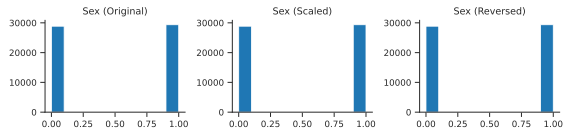

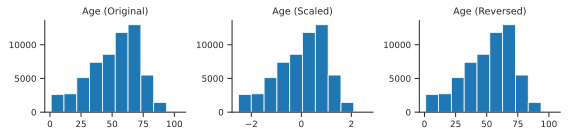

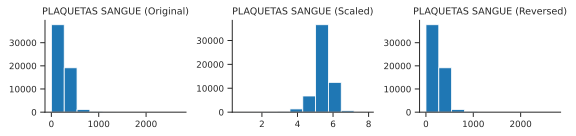

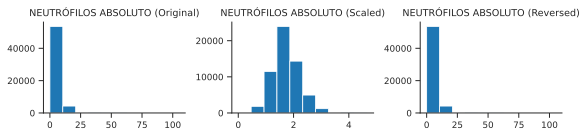

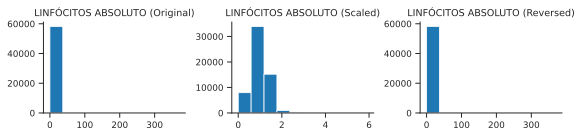

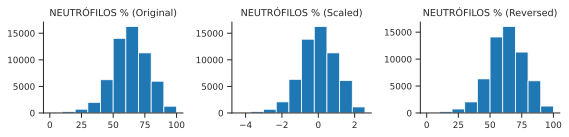

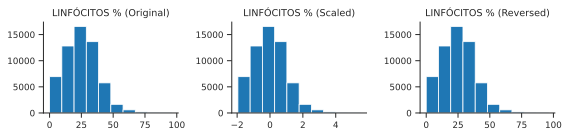

In [160]:
for i in range(X_scaled.shape[1]):
    fig, ax = plt.subplots(1, 3, figsize=(8, 2))
    ax[0].set_title(f'{columns[i]} (Original)')
    ax[0].hist(X_values[:,i])
    ax[1].set_title(f'{columns[i]} (Scaled)')
    ax[1].hist(X_scaled[:,i])
    ax[2].set_title(f'{columns[i]} (Reversed)')
    ax[2].hist(x_reversed[:,i])
    sns.despine()
    plt.tight_layout()
    plt.savefig(f'./fig/VAE_scale_{i}.png')
    plt.show()

## Training Functions

In [150]:
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

In [151]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [152]:
def reconstruction_fig(model, data, inv_scaler, scaled=True):
    model.eval()
    device = next(model.parameters()).device
    with torch.no_grad():
        data = data.to(device)
        output = model(data, compute_loss=False)
        recon = output.x_recon.cpu().numpy()
        recon[:,0] = np.round(recon[:,0], 0)
        data = data.cpu().numpy()

        if not scaled:
            data = inv_scaler.transform(data)
            recon = inv_scaler.transform(recon)
        else:
            data = zero_one_scaler.transform(data)
            recon = zero_one_scaler.transform(recon)

        if len(data.shape) == 1:
            data = data.reshape(1, -1)
            recon = recon.reshape(1, -1)
        recon[:,0] = recon[:,0].round(0) # Sex
        n_samples = data.shape[0]

        fig, ax = plt.subplots(n_samples, 1, figsize=(4, 2*n_samples))
        if n_samples == 1:
            ax = [ax]
        for i in range(n_samples):
            ax[i].plot(data[i], label='Original', color='blue', marker='o')
            ax[i].plot(recon[i], label='Reconstructed', color='blue', marker='o', linestyle='--')
            ax[i].set_xticks([])
            ax[i].set_yticks([])
            if not scaled:
                ax[i].set_ylim(0, 1)
        ax[0].legend()
        plt.tight_layout()
        return fig

def density_fig(model, data, inv_scaler, scaled=True):
    model.eval()
    with torch.no_grad():
        samples = model.samples(10000).to('cpu').detach().numpy()
        data = data.cpu().numpy()

        if not scaled:
            samples = inv_scaler.transform(samples)
            data = inv_scaler.transform(data)

        if len(data.shape) == 1:
            data = data.reshape(1, -1)
            recon = recon.reshape(1, -1)
        n_plots = data.shape[1]

        fig, ax = plt.subplots(n_plots, 1, figsize=(4, 2*n_plots))
        if n_plots == 1:
            ax = [ax]
        for i in range(n_plots):
            sns.kdeplot(data[:,i], label='Original', ax=ax[i], bw_adjust=0.5, color='blue')
            sns.kdeplot(samples[:,i], label='Synthetic', ax=ax[i], bw_adjust=0.5, color='blue', linestyle='--')
            ax[i].set_xticks([])
            ax[i].set_yticks([])
            ax[i].set_ylabel(columns[i])
        ax[0].legend()
        plt.tight_layout()
        return fig

In [153]:
def train(model, dataloader, optimizer, prev_updates, writer=None):
    """
    Trains the model on the given data.

    Args:
        model (nn.Module): The model to train.
        dataloader (torch.utils.data.DataLoader): The data loader.
        loss_fn: The loss function.
        optimizer: The optimizer.
    """
    model.train()  # Set the model to training mode
    device = next(model.parameters()).device
    batch_size = dataloader.batch_size

    for batch_idx, data in enumerate(tqdm(dataloader)):
        n_upd = prev_updates + batch_idx

        data = data.to(device)
        optimizer.zero_grad()  # Zero the gradients
        output = model(data)  # Forward pass
        loss = output.loss
        loss.backward(retain_graph=True)

        if n_upd % 100 == 0:
            # Calculate and log gradient norms
            total_norm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** (1. / 2)

            # print(f'Step {n_upd:,} (N samples: {n_upd*batch_size:,}), Loss: {loss.item():.4f} (Recon Bin: {output.loss_recon_bin.item():.4f}, Recon MSE: {output.loss_recon_mse.item():.4f}, Recon: {output.loss_recon.item():.4f}, KL: {output.loss_kl.item():.4f}) Grad: {total_norm:.4f}')
            print(f'Step {n_upd:,} (N samples: {n_upd*batch_size:,}), Loss: {loss.item():.4f} (Recon: {output.loss_recon.item():.4f}, KL: {output.loss_kl.item():.4f}) Grad: {total_norm:.4f}')

            if writer is not None:
                global_step = n_upd
                writer.add_scalar('Loss/Train', loss.item(), global_step)
                writer.add_scalar('Loss/Train/KLD', output.loss_kl.item(), global_step)
                writer.add_scalar('Loss/Train/Recon', output.loss_recon.item(), global_step)
                writer.add_scalar('Loss/Train/BCE', output.loss_recon_bin.item(), global_step)
                writer.add_scalar('Loss/Train/MSE', output.loss_recon_mse.item(), global_step)
                writer.add_scalar('GradNorm/Train', total_norm, global_step)

        # gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()  # Update the model parameters

    return prev_updates + len(dataloader)

In [154]:
def test(model, dataloader, cur_step, writer=None):
    """
    Tests the model on the given data.

    Args:
        model (nn.Module): The model to test.
        dataloader (torch.utils.data.DataLoader): The data loader.
        cur_step (int): The current step.
        writer: The TensorBoard writer.
    """
    device = next(model.parameters()).device

    model.eval()  # Set the model to evaluation mode
    test_loss = 0
    test_recon_loss = 0
    test_kl_loss = 0

    with torch.no_grad():
        for data in tqdm(dataloader, desc='Testing'):
            data = data.to(device)
            data = data.view(data.size(0), -1)  # Flatten the data

            output = model(data, compute_loss=True)  # Forward pass

            test_loss += output.loss.item()
            test_recon_loss += output.loss_recon.item()
            test_kl_loss += output.loss_kl.item()

    test_loss /= len(dataloader)
    test_recon_loss /= len(dataloader)
    test_kl_loss /= len(dataloader)
    print(f'====> Test set loss: {test_loss:.4f} (Recon: {test_recon_loss:.4f}, KLD: {test_kl_loss:.4f})')

    if writer is not None:
        writer.add_scalar('Loss/Test', test_loss, global_step=cur_step)
        writer.add_scalar('Loss/Test/Recon', output.loss_recon.item(), global_step=cur_step)
        writer.add_scalar('Loss/Test/KLD', output.loss_kl.item(), global_step=cur_step)

        inputs = next(iter(dataloader))
        writer.add_figure('Plots/Reconstruction', reconstruction_fig(model, inputs[:5], inverse_scaler, scaled=True), global_step=cur_step)
        all_samples = []
        for batch in dataloader:
            all_samples.append(batch)
        inputs = torch.cat(all_samples, dim=0)
        writer.add_figure('Plots/Density', density_fig(model, inputs, inverse_scaler, scaled=True), global_step=cur_step)

    return test_loss, test_recon_loss, test_kl_loss


In [155]:
def get_dataloaders(batch_size, X_train, X_test):
    train_loader = torch.utils.data.DataLoader(
        X_train,
        batch_size=batch_size,
        shuffle=True,
    )
    test_loader = torch.utils.data.DataLoader(
        X_test,
        batch_size=batch_size,
        shuffle=False,
    )
    return train_loader, test_loader


def build_vae(options):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = VAE(
        input_dim=7,
        hidden_dim=options['hidden_dim'],
        latent_dim=options['latent_dim'],
        beta=options['beta'],
        alpha=options['alpha'],
        n_hidden_layers=options['n_hidden_layers']
        ).to(device)
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=options['learning_rate'],
        weight_decay=options['weight_decay'])
    model_name = f'{options["study_name"]}/vae_{datetime.now().strftime("%Y%m%d-%H%M%S")}'
    writer = SummaryWriter(f'runs/{model_name}')
    print(f"Model name: {model_name}")
    return model, optimizer, writer


def train_vae(options, model, optimizer, writer, train_loader, test_loader):
    prev_updates = 0
    best_loss = float('inf')
    best_losses = {}

    for epoch in range(options['num_epochs']):
        print(f'Epoch {epoch+1}/{options["num_epochs"]}')
        prev_updates = train(model, train_loader, optimizer, prev_updates, writer=writer)
        test_loss, test_recon_loss, test_kl_loss = test(model, test_loader, prev_updates, writer=writer)
        if test_loss < best_loss:
            best_loss = test_loss
            best_losses = {
                'hparam/test_loss': test_loss,
                'hparam/recon_loss': test_recon_loss,
                'hparam/kl_loss': test_kl_loss,
            }
    writer.add_hparams(options, best_losses)
    writer.flush()
    writer.close()


def run_vae(options, X_train, X_test):
    model, optimizer, writer = build_vae(options)
    print(f"Number of parameters in the model: {count_parameters(model)}")

    train_loader, test_loader = get_dataloaders(options['batch_size'], X_train, X_test)
    train_vae(options, model, optimizer, writer, train_loader, test_loader)
    return model

## Model Training

In [156]:
options = {
    'batch_size': 128,
    'learning_rate': 1e-3,
    'weight_decay': 1e-2,
    'num_epochs': 50,
    'latent_dim': 5,
    'hidden_dim': 12,
    'n_hidden_layers': 4,
    'beta': 0.007,
    'alpha': 0.80,
    'study_name': 'vae06',
    }

model = run_vae(options, X_train, X_test)

Model name: vae06/vae_20240903-110025
Number of parameters in the model: 1637
Epoch 1/50


  0%|          | 0/365 [00:00<?, ?it/s]

  1%|          | 4/365 [00:00<00:09, 37.51it/s]

Step 0 (N samples: 0), Loss: 4.4140 (Recon: 4.4086, KL: 0.7833) Grad: 1.4635


 33%|███▎      | 119/365 [00:01<00:01, 137.30it/s]

Step 100 (N samples: 12,800), Loss: 0.7575 (Recon: 0.6395, KL: 16.8607) Grad: 2.4747


 61%|██████    | 223/365 [00:01<00:01, 141.52it/s]

Step 200 (N samples: 25,600), Loss: 0.3824 (Recon: 0.3335, KL: 6.9853) Grad: 0.1929


 90%|████████▉ | 327/365 [00:02<00:00, 136.40it/s]

Step 300 (N samples: 38,400), Loss: 0.4557 (Recon: 0.4117, KL: 6.2777) Grad: 0.4940


Testing: 100%|██████████| 92/92 [00:00<00:00, 307.06it/s]


====> Test set loss: 0.4227 (Recon: 0.3831, KLD: 5.6543)
Epoch 2/50


 16%|█▋        | 60/365 [00:00<00:02, 118.57it/s]

Step 400 (N samples: 51,200), Loss: 0.4042 (Recon: 0.3664, KL: 5.3980) Grad: 0.1813


 42%|████▏     | 155/365 [00:01<00:01, 149.35it/s]

Step 500 (N samples: 64,000), Loss: 0.3427 (Recon: 0.3077, KL: 4.9973) Grad: 0.3634


 73%|███████▎  | 266/365 [00:01<00:00, 150.67it/s]

Step 600 (N samples: 76,800), Loss: 0.2266 (Recon: 0.1891, KL: 5.3469) Grad: 0.3034


100%|██████████| 365/365 [00:02<00:00, 138.45it/s]


Step 700 (N samples: 89,600), Loss: 0.2618 (Recon: 0.2305, KL: 4.4597) Grad: 1.0186


Testing: 100%|██████████| 92/92 [00:00<00:00, 334.61it/s]


====> Test set loss: 0.2434 (Recon: 0.2124, KLD: 4.4193)
Epoch 3/50


 27%|██▋       | 98/365 [00:00<00:01, 134.04it/s]

Step 800 (N samples: 102,400), Loss: 0.2311 (Recon: 0.2034, KL: 3.9502) Grad: 0.6597


 52%|█████▏    | 190/365 [00:01<00:01, 151.30it/s]

Step 900 (N samples: 115,200), Loss: 0.2081 (Recon: 0.1844, KL: 3.3833) Grad: 0.5975


 82%|████████▏ | 300/365 [00:02<00:00, 149.77it/s]

Step 1,000 (N samples: 128,000), Loss: 0.1974 (Recon: 0.1749, KL: 3.2068) Grad: 0.7853


Testing: 100%|██████████| 92/92 [00:00<00:00, 326.63it/s]


====> Test set loss: 0.2148 (Recon: 0.1946, KLD: 2.8916)
Epoch 4/50


  1%|▏         | 5/365 [00:00<00:07, 45.15it/s]

Step 1,100 (N samples: 140,800), Loss: 0.1992 (Recon: 0.1787, KL: 2.9411) Grad: 0.4484


 35%|███▍      | 126/365 [00:01<00:01, 142.99it/s]

Step 1,200 (N samples: 153,600), Loss: 0.2385 (Recon: 0.2192, KL: 2.7613) Grad: 0.6972


 64%|██████▍   | 234/365 [00:01<00:00, 151.49it/s]

Step 1,300 (N samples: 166,400), Loss: 0.2461 (Recon: 0.2270, KL: 2.7289) Grad: 0.8109


 91%|█████████ | 331/365 [00:02<00:00, 153.23it/s]

Step 1,400 (N samples: 179,200), Loss: 0.2050 (Recon: 0.1861, KL: 2.6984) Grad: 0.2777


Testing: 100%|██████████| 92/92 [00:00<00:00, 322.62it/s]


====> Test set loss: 0.2104 (Recon: 0.1912, KLD: 2.7418)
Epoch 5/50


 16%|█▌        | 59/365 [00:00<00:02, 119.23it/s]

Step 1,500 (N samples: 192,000), Loss: 0.2157 (Recon: 0.1974, KL: 2.6219) Grad: 0.2595


 43%|████▎     | 157/365 [00:01<00:01, 153.95it/s]

Step 1,600 (N samples: 204,800), Loss: 0.1907 (Recon: 0.1731, KL: 2.5097) Grad: 0.4336


 74%|███████▍  | 271/365 [00:01<00:00, 156.99it/s]

Step 1,700 (N samples: 217,600), Loss: 0.2502 (Recon: 0.2317, KL: 2.6342) Grad: 0.9511


100%|██████████| 365/365 [00:02<00:00, 139.60it/s]


Step 1,800 (N samples: 230,400), Loss: 0.2356 (Recon: 0.2181, KL: 2.5028) Grad: 0.6586


Testing: 100%|██████████| 92/92 [00:00<00:00, 300.92it/s]


====> Test set loss: 0.2102 (Recon: 0.1927, KLD: 2.5073)
Epoch 6/50


 27%|██▋       | 100/365 [00:00<00:01, 141.72it/s]

Step 1,900 (N samples: 243,200), Loss: 0.2186 (Recon: 0.2011, KL: 2.4992) Grad: 0.6662


 53%|█████▎    | 195/365 [00:01<00:01, 150.94it/s]

Step 2,000 (N samples: 256,000), Loss: 0.2155 (Recon: 0.1982, KL: 2.4769) Grad: 0.4750


 81%|████████  | 296/365 [00:02<00:00, 159.03it/s]

Step 2,100 (N samples: 268,800), Loss: 0.1845 (Recon: 0.1675, KL: 2.4303) Grad: 0.2305


Testing: 100%|██████████| 92/92 [00:00<00:00, 355.44it/s]


====> Test set loss: 0.2061 (Recon: 0.1891, KLD: 2.4268)
Epoch 7/50


  5%|▍         | 17/365 [00:00<00:07, 49.12it/s]

Step 2,200 (N samples: 281,600), Loss: 0.1937 (Recon: 0.1764, KL: 2.4646) Grad: 0.2573


 38%|███▊      | 138/365 [00:01<00:01, 149.82it/s]

Step 2,300 (N samples: 294,400), Loss: 0.2200 (Recon: 0.2031, KL: 2.4189) Grad: 0.3437


 65%|██████▍   | 236/365 [00:01<00:00, 153.41it/s]

Step 2,400 (N samples: 307,200), Loss: 0.2336 (Recon: 0.2170, KL: 2.3631) Grad: 0.3460


 92%|█████████▏| 336/365 [00:02<00:00, 153.49it/s]

Step 2,500 (N samples: 320,000), Loss: 0.1889 (Recon: 0.1719, KL: 2.4238) Grad: 0.3157


Testing: 100%|██████████| 92/92 [00:00<00:00, 351.93it/s]


====> Test set loss: 0.2035 (Recon: 0.1863, KLD: 2.4606)
Epoch 8/50


 20%|█▉        | 72/365 [00:00<00:02, 127.93it/s]

Step 2,600 (N samples: 332,800), Loss: 0.2073 (Recon: 0.1903, KL: 2.4304) Grad: 0.3596


 48%|████▊     | 176/365 [00:01<00:01, 164.93it/s]

Step 2,700 (N samples: 345,600), Loss: 0.1801 (Recon: 0.1619, KL: 2.5897) Grad: 0.3982


 76%|███████▌  | 278/365 [00:02<00:00, 164.20it/s]

Step 2,800 (N samples: 358,400), Loss: 0.1828 (Recon: 0.1627, KL: 2.8750) Grad: 0.4553


100%|██████████| 365/365 [00:02<00:00, 143.37it/s]


Step 2,900 (N samples: 371,200), Loss: 0.2057 (Recon: 0.1820, KL: 3.3911) Grad: 0.4210


Testing: 100%|██████████| 92/92 [00:00<00:00, 339.96it/s]


====> Test set loss: 0.1936 (Recon: 0.1705, KLD: 3.3089)
Epoch 9/50


 27%|██▋       | 100/365 [00:00<00:01, 139.46it/s]

Step 3,000 (N samples: 384,000), Loss: 0.1807 (Recon: 0.1576, KL: 3.2987) Grad: 1.0074


 58%|█████▊    | 210/365 [00:01<00:01, 152.55it/s]

Step 3,100 (N samples: 396,800), Loss: 0.1917 (Recon: 0.1677, KL: 3.4350) Grad: 0.2311


 84%|████████▍ | 308/365 [00:02<00:00, 148.02it/s]

Step 3,200 (N samples: 409,600), Loss: 0.1866 (Recon: 0.1627, KL: 3.4253) Grad: 0.7347


Testing: 100%|██████████| 92/92 [00:00<00:00, 321.10it/s]


====> Test set loss: 0.1885 (Recon: 0.1648, KLD: 3.3764)
Epoch 10/50


  8%|▊         | 30/365 [00:00<00:05, 62.93it/s]

Step 3,300 (N samples: 422,400), Loss: 0.1783 (Recon: 0.1554, KL: 3.2745) Grad: 0.6559


 40%|███▉      | 145/365 [00:01<00:01, 156.57it/s]

Step 3,400 (N samples: 435,200), Loss: 0.1740 (Recon: 0.1519, KL: 3.1636) Grad: 0.1813


 68%|██████▊   | 248/365 [00:01<00:00, 167.51it/s]

Step 3,500 (N samples: 448,000), Loss: 0.1982 (Recon: 0.1735, KL: 3.5300) Grad: 0.3783


 91%|█████████ | 333/365 [00:02<00:00, 161.34it/s]

Step 3,600 (N samples: 460,800), Loss: 0.1879 (Recon: 0.1631, KL: 3.5482) Grad: 0.7423


Testing: 100%|██████████| 92/92 [00:00<00:00, 319.14it/s]


====> Test set loss: 0.1838 (Recon: 0.1595, KLD: 3.4784)
Epoch 11/50


 19%|█▉        | 69/365 [00:00<00:02, 112.63it/s]

Step 3,700 (N samples: 473,600), Loss: 0.1832 (Recon: 0.1593, KL: 3.4070) Grad: 0.2040


 49%|████▉     | 179/365 [00:01<00:01, 151.37it/s]

Step 3,800 (N samples: 486,400), Loss: 0.1821 (Recon: 0.1585, KL: 3.3740) Grad: 0.3685


 76%|███████▌  | 277/365 [00:02<00:00, 153.36it/s]

Step 3,900 (N samples: 499,200), Loss: 0.1773 (Recon: 0.1518, KL: 3.6442) Grad: 0.2009


100%|██████████| 365/365 [00:02<00:00, 134.13it/s]


Step 4,000 (N samples: 512,000), Loss: 0.1700 (Recon: 0.1455, KL: 3.5008) Grad: 0.4684


Testing: 100%|██████████| 92/92 [00:00<00:00, 340.72it/s]


====> Test set loss: 0.1780 (Recon: 0.1538, KLD: 3.4657)
Epoch 12/50


 30%|██▉       | 109/365 [00:01<00:01, 131.99it/s]

Step 4,100 (N samples: 524,800), Loss: 0.1698 (Recon: 0.1457, KL: 3.4418) Grad: 0.2095


 55%|█████▌    | 201/365 [00:01<00:01, 140.52it/s]

Step 4,200 (N samples: 537,600), Loss: 0.1665 (Recon: 0.1426, KL: 3.4166) Grad: 0.3607


 86%|████████▌ | 313/365 [00:02<00:00, 148.04it/s]

Step 4,300 (N samples: 550,400), Loss: 0.1683 (Recon: 0.1425, KL: 3.6783) Grad: 0.4266


Testing: 100%|██████████| 92/92 [00:00<00:00, 307.21it/s]


====> Test set loss: 0.1597 (Recon: 0.1340, KLD: 3.6718)
Epoch 13/50


 10%|█         | 37/365 [00:00<00:04, 80.90it/s]

Step 4,400 (N samples: 563,200), Loss: 0.1870 (Recon: 0.1605, KL: 3.7851) Grad: 0.5656


 39%|███▉      | 144/365 [00:01<00:01, 143.27it/s]

Step 4,500 (N samples: 576,000), Loss: 0.1267 (Recon: 0.0989, KL: 3.9641) Grad: 0.8065


 66%|██████▋   | 242/365 [00:01<00:00, 159.48it/s]

Step 4,600 (N samples: 588,800), Loss: 0.1087 (Recon: 0.0793, KL: 4.2006) Grad: 0.2780


 93%|█████████▎| 340/365 [00:02<00:00, 156.32it/s]

Step 4,700 (N samples: 601,600), Loss: 0.1101 (Recon: 0.0814, KL: 4.1092) Grad: 0.7233


Testing: 100%|██████████| 92/92 [00:00<00:00, 319.80it/s]


====> Test set loss: 0.1170 (Recon: 0.0891, KLD: 3.9894)
Epoch 14/50


 22%|██▏       | 82/365 [00:00<00:02, 128.36it/s]

Step 4,800 (N samples: 614,400), Loss: 0.1178 (Recon: 0.0901, KL: 3.9646) Grad: 0.2446


 50%|█████     | 184/365 [00:01<00:01, 135.65it/s]

Step 4,900 (N samples: 627,200), Loss: 0.1114 (Recon: 0.0838, KL: 3.9398) Grad: 0.3681


 76%|███████▌  | 278/365 [00:02<00:00, 150.22it/s]

Step 5,000 (N samples: 640,000), Loss: 0.1161 (Recon: 0.0885, KL: 3.9357) Grad: 0.6818


100%|██████████| 365/365 [00:02<00:00, 128.86it/s]


Step 5,100 (N samples: 652,800), Loss: 0.1413 (Recon: 0.1136, KL: 3.9513) Grad: 0.7872


Testing: 100%|██████████| 92/92 [00:00<00:00, 326.74it/s]


====> Test set loss: 0.1150 (Recon: 0.0876, KLD: 3.9071)
Epoch 15/50


 29%|██▉       | 107/365 [00:00<00:01, 143.32it/s]

Step 5,200 (N samples: 665,600), Loss: 0.1200 (Recon: 0.0930, KL: 3.8675) Grad: 0.4359


 60%|█████▉    | 218/365 [00:01<00:00, 153.42it/s]

Step 5,300 (N samples: 678,400), Loss: 0.1206 (Recon: 0.0920, KL: 4.0879) Grad: 0.8413


 87%|████████▋ | 316/365 [00:02<00:00, 158.32it/s]

Step 5,400 (N samples: 691,200), Loss: 0.1044 (Recon: 0.0759, KL: 4.0589) Grad: 0.3984


Testing: 100%|██████████| 92/92 [00:00<00:00, 342.76it/s]


====> Test set loss: 0.1105 (Recon: 0.0833, KLD: 3.8957)
Epoch 16/50


 13%|█▎        | 47/365 [00:00<00:03, 94.53it/s]

Step 5,500 (N samples: 704,000), Loss: 0.1233 (Recon: 0.0967, KL: 3.7951) Grad: 0.6339


 39%|███▊      | 141/365 [00:01<00:01, 142.42it/s]

Step 5,600 (N samples: 716,800), Loss: 0.1113 (Recon: 0.0838, KL: 3.9363) Grad: 0.6256


 68%|██████▊   | 250/365 [00:02<00:00, 154.07it/s]

Step 5,700 (N samples: 729,600), Loss: 0.1126 (Recon: 0.0849, KL: 3.9549) Grad: 0.3397


 95%|█████████▌| 347/365 [00:02<00:00, 154.32it/s]

Step 5,800 (N samples: 742,400), Loss: 0.1112 (Recon: 0.0830, KL: 4.0316) Grad: 0.3189


Testing: 100%|██████████| 92/92 [00:00<00:00, 339.73it/s]


====> Test set loss: 0.1114 (Recon: 0.0841, KLD: 3.8971)
Epoch 17/50


 23%|██▎       | 83/365 [00:00<00:02, 131.25it/s]

Step 5,900 (N samples: 755,200), Loss: 0.1487 (Recon: 0.1218, KL: 3.8391) Grad: 0.9480


 48%|████▊     | 176/365 [00:01<00:01, 144.58it/s]

Step 6,000 (N samples: 768,000), Loss: 0.1280 (Recon: 0.0996, KL: 4.0468) Grad: 0.3790


 79%|███████▊  | 287/365 [00:02<00:00, 152.16it/s]

Step 6,100 (N samples: 780,800), Loss: 0.1104 (Recon: 0.0833, KL: 3.8779) Grad: 0.5344


100%|██████████| 365/365 [00:02<00:00, 132.60it/s]


Step 6,200 (N samples: 793,600), Loss: 0.1042 (Recon: 0.0769, KL: 3.8968) Grad: 0.5625


Testing: 100%|██████████| 92/92 [00:00<00:00, 312.80it/s]


====> Test set loss: 0.1099 (Recon: 0.0829, KLD: 3.8619)
Epoch 18/50


 35%|███▍      | 126/365 [00:01<00:01, 152.53it/s]

Step 6,300 (N samples: 806,400), Loss: 0.1079 (Recon: 0.0808, KL: 3.8754) Grad: 0.4336


 61%|██████    | 221/365 [00:01<00:00, 154.23it/s]

Step 6,400 (N samples: 819,200), Loss: 0.1111 (Recon: 0.0844, KL: 3.8201) Grad: 0.5483


 87%|████████▋ | 318/365 [00:02<00:00, 154.22it/s]

Step 6,500 (N samples: 832,000), Loss: 0.0995 (Recon: 0.0731, KL: 3.7804) Grad: 0.7797


Testing: 100%|██████████| 92/92 [00:00<00:00, 294.56it/s]


====> Test set loss: 0.1088 (Recon: 0.0817, KLD: 3.8786)
Epoch 19/50


 16%|█▌        | 59/365 [00:00<00:02, 120.99it/s]

Step 6,600 (N samples: 844,800), Loss: 0.1173 (Recon: 0.0898, KL: 3.9285) Grad: 0.6321


 41%|████      | 150/365 [00:01<00:01, 137.96it/s]

Step 6,700 (N samples: 857,600), Loss: 0.1028 (Recon: 0.0756, KL: 3.8900) Grad: 0.6881


 70%|██████▉   | 255/365 [00:01<00:00, 145.17it/s]

Step 6,800 (N samples: 870,400), Loss: 0.1087 (Recon: 0.0815, KL: 3.8833) Grad: 0.5433


 95%|█████████▌| 347/365 [00:02<00:00, 147.75it/s]

Step 6,900 (N samples: 883,200), Loss: 0.1201 (Recon: 0.0919, KL: 4.0287) Grad: 0.6122


Testing: 100%|██████████| 92/92 [00:00<00:00, 217.25it/s]


====> Test set loss: 0.1103 (Recon: 0.0830, KLD: 3.9022)
Epoch 20/50


 23%|██▎       | 83/365 [00:00<00:02, 129.56it/s]

Step 7,000 (N samples: 896,000), Loss: 0.1051 (Recon: 0.0783, KL: 3.8269) Grad: 0.6952


 53%|█████▎    | 193/365 [00:01<00:01, 145.15it/s]

Step 7,100 (N samples: 908,800), Loss: 0.1081 (Recon: 0.0817, KL: 3.7613) Grad: 0.2971


 78%|███████▊  | 285/365 [00:02<00:00, 145.32it/s]

Step 7,200 (N samples: 921,600), Loss: 0.1002 (Recon: 0.0732, KL: 3.8446) Grad: 1.1580


Testing: 100%|██████████| 92/92 [00:00<00:00, 321.82it/s]


====> Test set loss: 0.1077 (Recon: 0.0801, KLD: 3.9423)
Epoch 21/50


  1%|          | 4/365 [00:00<00:10, 35.26it/s]

Step 7,300 (N samples: 934,400), Loss: 0.0952 (Recon: 0.0686, KL: 3.7993) Grad: 0.6097


 32%|███▏      | 118/365 [00:01<00:01, 131.72it/s]

Step 7,400 (N samples: 947,200), Loss: 0.1309 (Recon: 0.1034, KL: 3.9340) Grad: 1.0581


 59%|█████▉    | 217/365 [00:01<00:01, 134.52it/s]

Step 7,500 (N samples: 960,000), Loss: 0.1237 (Recon: 0.0958, KL: 3.9787) Grad: 0.4945


 86%|████████▋ | 315/365 [00:02<00:00, 128.94it/s]

Step 7,600 (N samples: 972,800), Loss: 0.1161 (Recon: 0.0897, KL: 3.7634) Grad: 0.5559


Testing: 100%|██████████| 92/92 [00:00<00:00, 309.08it/s]


====> Test set loss: 0.1069 (Recon: 0.0795, KLD: 3.9140)
Epoch 22/50


 16%|█▋        | 60/365 [00:00<00:02, 118.32it/s]

Step 7,700 (N samples: 985,600), Loss: 0.1101 (Recon: 0.0840, KL: 3.7233) Grad: 0.8321


 41%|████      | 150/365 [00:01<00:01, 140.12it/s]

Step 7,800 (N samples: 998,400), Loss: 0.0997 (Recon: 0.0723, KL: 3.9205) Grad: 0.3749


 72%|███████▏  | 261/365 [00:02<00:00, 151.80it/s]

Step 7,900 (N samples: 1,011,200), Loss: 0.1018 (Recon: 0.0752, KL: 3.7999) Grad: 0.4698


 98%|█████████▊| 357/365 [00:02<00:00, 152.65it/s]

Step 8,000 (N samples: 1,024,000), Loss: 0.0992 (Recon: 0.0721, KL: 3.8770) Grad: 0.4266


Testing: 100%|██████████| 92/92 [00:00<00:00, 324.67it/s]


====> Test set loss: 0.1087 (Recon: 0.0813, KLD: 3.9160)
Epoch 23/50


 27%|██▋       | 99/365 [00:00<00:02, 132.09it/s]

Step 8,100 (N samples: 1,036,800), Loss: 0.1292 (Recon: 0.1015, KL: 3.9577) Grad: 0.7102


 52%|█████▏    | 188/365 [00:01<00:01, 147.13it/s]

Step 8,200 (N samples: 1,049,600), Loss: 0.1068 (Recon: 0.0793, KL: 3.9285) Grad: 0.7586


 78%|███████▊  | 285/365 [00:02<00:00, 148.55it/s]

Step 8,300 (N samples: 1,062,400), Loss: 0.1114 (Recon: 0.0846, KL: 3.8336) Grad: 0.4245


Testing: 100%|██████████| 92/92 [00:00<00:00, 343.59it/s]


====> Test set loss: 0.1096 (Recon: 0.0829, KLD: 3.8117)
Epoch 24/50


  1%|▏         | 5/365 [00:00<00:07, 45.89it/s]

Step 8,400 (N samples: 1,075,200), Loss: 0.1053 (Recon: 0.0779, KL: 3.9251) Grad: 0.8150


 36%|███▌      | 131/365 [00:01<00:01, 143.22it/s]

Step 8,500 (N samples: 1,088,000), Loss: 0.1038 (Recon: 0.0768, KL: 3.8568) Grad: 0.4858


 61%|██████    | 223/365 [00:01<00:00, 149.67it/s]

Step 8,600 (N samples: 1,100,800), Loss: 0.1113 (Recon: 0.0841, KL: 3.8848) Grad: 0.4583


 92%|█████████▏| 337/365 [00:02<00:00, 153.52it/s]

Step 8,700 (N samples: 1,113,600), Loss: 0.1386 (Recon: 0.1124, KL: 3.7488) Grad: 0.5100


Testing: 100%|██████████| 92/92 [00:00<00:00, 323.81it/s]


====> Test set loss: 0.1093 (Recon: 0.0819, KLD: 3.9186)
Epoch 25/50


 19%|█▉        | 70/365 [00:00<00:02, 123.47it/s]

Step 8,800 (N samples: 1,126,400), Loss: 0.1207 (Recon: 0.0926, KL: 4.0202) Grad: 0.6833


 45%|████▌     | 165/365 [00:01<00:01, 143.67it/s]

Step 8,900 (N samples: 1,139,200), Loss: 0.1175 (Recon: 0.0900, KL: 3.9392) Grad: 0.4673


 71%|███████   | 260/365 [00:01<00:00, 147.51it/s]

Step 9,000 (N samples: 1,152,000), Loss: 0.1018 (Recon: 0.0743, KL: 3.9278) Grad: 0.5318


100%|██████████| 365/365 [00:02<00:00, 134.41it/s]


Step 9,100 (N samples: 1,164,800), Loss: 0.0956 (Recon: 0.0679, KL: 3.9570) Grad: 0.3271


Testing: 100%|██████████| 92/92 [00:00<00:00, 333.73it/s]


====> Test set loss: 0.1064 (Recon: 0.0792, KLD: 3.8918)
Epoch 26/50


 27%|██▋       | 97/365 [00:00<00:02, 131.76it/s]

Step 9,200 (N samples: 1,177,600), Loss: 0.1161 (Recon: 0.0891, KL: 3.8560) Grad: 0.6605


 55%|█████▌    | 202/365 [00:01<00:01, 136.93it/s]

Step 9,300 (N samples: 1,190,400), Loss: 0.0963 (Recon: 0.0699, KL: 3.7718) Grad: 0.2543


 82%|████████▏ | 300/365 [00:02<00:00, 155.06it/s]

Step 9,400 (N samples: 1,203,200), Loss: 0.1015 (Recon: 0.0725, KL: 4.1501) Grad: 0.4169


Testing: 100%|██████████| 92/92 [00:00<00:00, 328.53it/s]


====> Test set loss: 0.1051 (Recon: 0.0773, KLD: 3.9595)
Epoch 27/50


  6%|▌         | 22/365 [00:00<00:06, 49.22it/s]

Step 9,500 (N samples: 1,216,000), Loss: 0.1209 (Recon: 0.0932, KL: 3.9595) Grad: 0.3995


 38%|███▊      | 139/365 [00:01<00:01, 142.92it/s]

Step 9,600 (N samples: 1,228,800), Loss: 0.1171 (Recon: 0.0901, KL: 3.8528) Grad: 0.7418


 63%|██████▎   | 231/365 [00:01<00:00, 144.50it/s]

Step 9,700 (N samples: 1,241,600), Loss: 0.1117 (Recon: 0.0844, KL: 3.8956) Grad: 0.5171


 90%|████████▉ | 327/365 [00:02<00:00, 153.80it/s]

Step 9,800 (N samples: 1,254,400), Loss: 0.1093 (Recon: 0.0819, KL: 3.9142) Grad: 0.2759


Testing: 100%|██████████| 92/92 [00:00<00:00, 312.21it/s]


====> Test set loss: 0.1047 (Recon: 0.0773, KLD: 3.9129)
Epoch 28/50


 17%|█▋        | 61/365 [00:00<00:02, 108.39it/s]

Step 9,900 (N samples: 1,267,200), Loss: 0.1130 (Recon: 0.0842, KL: 4.1092) Grad: 0.3918


 48%|████▊     | 175/365 [00:01<00:01, 149.69it/s]

Step 10,000 (N samples: 1,280,000), Loss: 0.1019 (Recon: 0.0748, KL: 3.8789) Grad: 0.3463


 74%|███████▍  | 270/365 [00:02<00:00, 150.30it/s]

Step 10,100 (N samples: 1,292,800), Loss: 0.1052 (Recon: 0.0771, KL: 4.0254) Grad: 0.4774


100%|██████████| 365/365 [00:02<00:00, 132.45it/s]


Step 10,200 (N samples: 1,305,600), Loss: 0.1049 (Recon: 0.0776, KL: 3.9113) Grad: 0.7195


Testing: 100%|██████████| 92/92 [00:00<00:00, 330.84it/s]


====> Test set loss: 0.1053 (Recon: 0.0773, KLD: 3.9936)
Epoch 29/50


 26%|██▌       | 94/365 [00:00<00:02, 117.82it/s]

Step 10,300 (N samples: 1,318,400), Loss: 0.1012 (Recon: 0.0724, KL: 4.1124) Grad: 0.7282


 55%|█████▌    | 201/365 [00:01<00:01, 148.31it/s]

Step 10,400 (N samples: 1,331,200), Loss: 0.1054 (Recon: 0.0774, KL: 4.0033) Grad: 0.3874


 81%|████████▏ | 297/365 [00:02<00:00, 153.40it/s]

Step 10,500 (N samples: 1,344,000), Loss: 0.1000 (Recon: 0.0712, KL: 4.1089) Grad: 0.4336


Testing: 100%|██████████| 92/92 [00:00<00:00, 318.17it/s]


====> Test set loss: 0.1046 (Recon: 0.0769, KLD: 3.9573)
Epoch 30/50


  7%|▋         | 24/365 [00:00<00:05, 58.84it/s]

Step 10,600 (N samples: 1,356,800), Loss: 0.1056 (Recon: 0.0773, KL: 4.0391) Grad: 0.8723


 38%|███▊      | 137/365 [00:01<00:01, 133.03it/s]

Step 10,700 (N samples: 1,369,600), Loss: 0.0962 (Recon: 0.0685, KL: 3.9585) Grad: 0.4567


 65%|██████▍   | 237/365 [00:02<00:00, 134.18it/s]

Step 10,800 (N samples: 1,382,400), Loss: 0.1072 (Recon: 0.0781, KL: 4.1517) Grad: 0.6363


 92%|█████████▏| 337/365 [00:02<00:00, 136.75it/s]

Step 10,900 (N samples: 1,395,200), Loss: 0.1007 (Recon: 0.0725, KL: 4.0274) Grad: 0.9181


Testing: 100%|██████████| 92/92 [00:00<00:00, 218.97it/s]


====> Test set loss: 0.1037 (Recon: 0.0760, KLD: 3.9615)
Epoch 31/50


 19%|█▊        | 68/365 [00:00<00:02, 114.89it/s]

Step 11,000 (N samples: 1,408,000), Loss: 0.1026 (Recon: 0.0742, KL: 4.0544) Grad: 0.9063


 49%|████▉     | 180/365 [00:01<00:01, 141.58it/s]

Step 11,100 (N samples: 1,420,800), Loss: 0.1057 (Recon: 0.0772, KL: 4.0683) Grad: 0.3030


 75%|███████▌  | 275/365 [00:02<00:00, 151.99it/s]

Step 11,200 (N samples: 1,433,600), Loss: 0.1062 (Recon: 0.0785, KL: 3.9671) Grad: 0.9332


100%|██████████| 365/365 [00:02<00:00, 127.63it/s]


Step 11,300 (N samples: 1,446,400), Loss: 0.0954 (Recon: 0.0669, KL: 4.0714) Grad: 0.5042


Testing: 100%|██████████| 92/92 [00:00<00:00, 278.15it/s]


====> Test set loss: 0.1031 (Recon: 0.0747, KLD: 4.0615)
Epoch 32/50


 30%|██▉       | 109/365 [00:01<00:02, 118.71it/s]

Step 11,400 (N samples: 1,459,200), Loss: 0.1117 (Recon: 0.0835, KL: 4.0303) Grad: 0.4894


 58%|█████▊    | 211/365 [00:01<00:01, 133.07it/s]

Step 11,500 (N samples: 1,472,000), Loss: 0.1117 (Recon: 0.0824, KL: 4.1871) Grad: 0.6226


 86%|████████▌ | 313/365 [00:02<00:00, 139.11it/s]

Step 11,600 (N samples: 1,484,800), Loss: 0.0973 (Recon: 0.0658, KL: 4.5046) Grad: 0.5412


Testing: 100%|██████████| 92/92 [00:00<00:00, 341.10it/s]


====> Test set loss: 0.0974 (Recon: 0.0648, KLD: 4.6577)
Epoch 33/50


  8%|▊         | 31/365 [00:00<00:05, 64.04it/s]

Step 11,700 (N samples: 1,497,600), Loss: 0.1002 (Recon: 0.0677, KL: 4.6372) Grad: 0.4219


 37%|███▋      | 136/365 [00:01<00:01, 133.52it/s]

Step 11,800 (N samples: 1,510,400), Loss: 0.0991 (Recon: 0.0653, KL: 4.8340) Grad: 0.5178


 67%|██████▋   | 246/365 [00:02<00:00, 146.01it/s]

Step 11,900 (N samples: 1,523,200), Loss: 0.0867 (Recon: 0.0518, KL: 4.9901) Grad: 0.5698


 93%|█████████▎| 338/365 [00:02<00:00, 138.40it/s]

Step 12,000 (N samples: 1,536,000), Loss: 0.1056 (Recon: 0.0710, KL: 4.9513) Grad: 0.2982


Testing: 100%|██████████| 92/92 [00:00<00:00, 333.93it/s]


====> Test set loss: 0.0970 (Recon: 0.0625, KLD: 4.9341)
Epoch 34/50


 20%|██        | 74/365 [00:00<00:02, 111.94it/s]

Step 12,100 (N samples: 1,548,800), Loss: 0.0994 (Recon: 0.0654, KL: 4.8598) Grad: 0.3546


 50%|████▉     | 182/365 [00:01<00:01, 130.71it/s]

Step 12,200 (N samples: 1,561,600), Loss: 0.0926 (Recon: 0.0576, KL: 4.9961) Grad: 0.4345


 74%|███████▍  | 270/365 [00:02<00:00, 138.19it/s]

Step 12,300 (N samples: 1,574,400), Loss: 0.0927 (Recon: 0.0584, KL: 4.9135) Grad: 0.2627


100%|██████████| 365/365 [00:02<00:00, 123.59it/s]


Step 12,400 (N samples: 1,587,200), Loss: 0.0900 (Recon: 0.0556, KL: 4.9056) Grad: 0.3597


Testing: 100%|██████████| 92/92 [00:00<00:00, 335.55it/s]


====> Test set loss: 0.0927 (Recon: 0.0590, KLD: 4.8141)
Epoch 35/50


 30%|██▉       | 109/365 [00:00<00:01, 139.64it/s]

Step 12,500 (N samples: 1,600,000), Loss: 0.0863 (Recon: 0.0531, KL: 4.7497) Grad: 0.7320


 60%|█████▉    | 218/365 [00:01<00:00, 151.71it/s]

Step 12,600 (N samples: 1,612,800), Loss: 0.0873 (Recon: 0.0527, KL: 4.9362) Grad: 0.4983


 87%|████████▋ | 316/365 [00:02<00:00, 155.17it/s]

Step 12,700 (N samples: 1,625,600), Loss: 0.0910 (Recon: 0.0555, KL: 5.0689) Grad: 0.6791


Testing: 100%|██████████| 92/92 [00:00<00:00, 337.54it/s]


====> Test set loss: 0.0910 (Recon: 0.0573, KLD: 4.8042)
Epoch 36/50


 14%|█▍        | 51/365 [00:00<00:03, 102.85it/s]

Step 12,800 (N samples: 1,638,400), Loss: 0.0947 (Recon: 0.0600, KL: 4.9583) Grad: 0.2575


 40%|███▉      | 145/365 [00:01<00:01, 144.43it/s]

Step 12,900 (N samples: 1,651,200), Loss: 0.1079 (Recon: 0.0729, KL: 5.0092) Grad: 0.2790


 66%|██████▋   | 242/365 [00:01<00:00, 147.70it/s]

Step 13,000 (N samples: 1,664,000), Loss: 0.0840 (Recon: 0.0497, KL: 4.8921) Grad: 0.7819


 96%|█████████▋| 352/365 [00:02<00:00, 152.39it/s]

Step 13,100 (N samples: 1,676,800), Loss: 0.0928 (Recon: 0.0586, KL: 4.8798) Grad: 0.6216


Testing: 100%|██████████| 92/92 [00:00<00:00, 322.16it/s]


====> Test set loss: 0.0897 (Recon: 0.0559, KLD: 4.8393)
Epoch 37/50


 23%|██▎       | 85/365 [00:00<00:02, 134.67it/s]

Step 13,200 (N samples: 1,689,600), Loss: 0.0830 (Recon: 0.0483, KL: 4.9546) Grad: 0.2398


 50%|█████     | 183/365 [00:01<00:01, 154.02it/s]

Step 13,300 (N samples: 1,702,400), Loss: 0.0914 (Recon: 0.0567, KL: 4.9596) Grad: 0.5461


 77%|███████▋  | 281/365 [00:02<00:00, 154.36it/s]

Step 13,400 (N samples: 1,715,200), Loss: 0.0853 (Recon: 0.0505, KL: 4.9692) Grad: 0.2653


100%|██████████| 365/365 [00:02<00:00, 138.82it/s]


Step 13,500 (N samples: 1,728,000), Loss: 0.0865 (Recon: 0.0527, KL: 4.8208) Grad: 0.3507


Testing: 100%|██████████| 92/92 [00:00<00:00, 338.35it/s]


====> Test set loss: 0.0892 (Recon: 0.0551, KLD: 4.8737)
Epoch 38/50


 30%|███       | 111/365 [00:00<00:01, 148.23it/s]

Step 13,600 (N samples: 1,740,800), Loss: 0.0805 (Recon: 0.0478, KL: 4.6634) Grad: 1.0005


 62%|██████▏   | 226/365 [00:01<00:00, 156.41it/s]

Step 13,700 (N samples: 1,753,600), Loss: 0.0895 (Recon: 0.0561, KL: 4.7674) Grad: 0.3605


 89%|████████▉ | 324/365 [00:02<00:00, 155.31it/s]

Step 13,800 (N samples: 1,766,400), Loss: 0.0935 (Recon: 0.0605, KL: 4.7128) Grad: 1.0002


Testing: 100%|██████████| 92/92 [00:00<00:00, 324.42it/s]


====> Test set loss: 0.0898 (Recon: 0.0555, KLD: 4.9018)
Epoch 39/50


 14%|█▍        | 52/365 [00:00<00:03, 99.25it/s]

Step 13,900 (N samples: 1,779,200), Loss: 0.0862 (Recon: 0.0529, KL: 4.7579) Grad: 0.2861


 44%|████▍     | 162/365 [00:01<00:01, 151.62it/s]

Step 14,000 (N samples: 1,792,000), Loss: 0.0846 (Recon: 0.0516, KL: 4.7225) Grad: 1.1636


 70%|███████   | 257/365 [00:02<00:00, 149.08it/s]

Step 14,100 (N samples: 1,804,800), Loss: 0.0849 (Recon: 0.0514, KL: 4.7882) Grad: 0.7406


 97%|█████████▋| 353/365 [00:02<00:00, 151.62it/s]

Step 14,200 (N samples: 1,817,600), Loss: 0.0861 (Recon: 0.0511, KL: 5.0003) Grad: 0.8538


Testing: 100%|██████████| 92/92 [00:00<00:00, 337.87it/s]


====> Test set loss: 0.0913 (Recon: 0.0572, KLD: 4.8688)
Epoch 40/50


 27%|██▋       | 98/365 [00:00<00:01, 140.97it/s]

Step 14,300 (N samples: 1,830,400), Loss: 0.0873 (Recon: 0.0540, KL: 4.7667) Grad: 0.7033


 53%|█████▎    | 194/365 [00:01<00:01, 156.17it/s]

Step 14,400 (N samples: 1,843,200), Loss: 0.0838 (Recon: 0.0504, KL: 4.7620) Grad: 0.7675


 80%|███████▉  | 291/365 [00:02<00:00, 153.68it/s]

Step 14,500 (N samples: 1,856,000), Loss: 0.0935 (Recon: 0.0588, KL: 4.9562) Grad: 0.8583


Testing: 100%|██████████| 92/92 [00:00<00:00, 337.70it/s]


====> Test set loss: 0.0892 (Recon: 0.0547, KLD: 4.9275)
Epoch 41/50


  1%|▏         | 5/365 [00:00<00:07, 45.19it/s]

Step 14,600 (N samples: 1,868,800), Loss: 0.0933 (Recon: 0.0586, KL: 4.9566) Grad: 0.5369


 33%|███▎      | 121/365 [00:01<00:01, 144.97it/s]

Step 14,700 (N samples: 1,881,600), Loss: 0.1032 (Recon: 0.0667, KL: 5.2171) Grad: 0.4912


 60%|█████▉    | 218/365 [00:01<00:00, 150.54it/s]

Step 14,800 (N samples: 1,894,400), Loss: 0.0818 (Recon: 0.0485, KL: 4.7586) Grad: 0.8257


 86%|████████▌ | 314/365 [00:02<00:00, 152.50it/s]

Step 14,900 (N samples: 1,907,200), Loss: 0.0879 (Recon: 0.0543, KL: 4.7934) Grad: 1.2475


Testing: 100%|██████████| 92/92 [00:00<00:00, 314.20it/s]


====> Test set loss: 0.0901 (Recon: 0.0560, KLD: 4.8754)
Epoch 42/50


 15%|█▌        | 55/365 [00:00<00:02, 110.14it/s]

Step 15,000 (N samples: 1,920,000), Loss: 0.0842 (Recon: 0.0502, KL: 4.8573) Grad: 0.3304


 45%|████▍     | 163/365 [00:01<00:01, 140.39it/s]

Step 15,100 (N samples: 1,932,800), Loss: 0.0820 (Recon: 0.0482, KL: 4.8189) Grad: 0.5583


 69%|██████▉   | 253/365 [00:02<00:00, 136.49it/s]

Step 15,200 (N samples: 1,945,600), Loss: 0.0838 (Recon: 0.0495, KL: 4.9026) Grad: 0.3416


 97%|█████████▋| 355/365 [00:02<00:00, 141.01it/s]

Step 15,300 (N samples: 1,958,400), Loss: 0.0868 (Recon: 0.0519, KL: 4.9788) Grad: 0.5967


Testing: 100%|██████████| 92/92 [00:00<00:00, 334.54it/s]


====> Test set loss: 0.0886 (Recon: 0.0547, KLD: 4.8459)
Epoch 43/50


 24%|██▍       | 89/365 [00:00<00:02, 115.65it/s]

Step 15,400 (N samples: 1,971,200), Loss: 0.0847 (Recon: 0.0514, KL: 4.7622) Grad: 0.6225


 52%|█████▏    | 188/365 [00:01<00:01, 137.90it/s]

Step 15,500 (N samples: 1,984,000), Loss: 0.0933 (Recon: 0.0588, KL: 4.9257) Grad: 0.4364


 81%|████████  | 295/365 [00:02<00:00, 143.52it/s]

Step 15,600 (N samples: 1,996,800), Loss: 0.0892 (Recon: 0.0540, KL: 5.0220) Grad: 0.7245


Testing: 100%|██████████| 92/92 [00:00<00:00, 308.40it/s]


====> Test set loss: 0.0900 (Recon: 0.0554, KLD: 4.9416)
Epoch 44/50


  1%|▏         | 5/365 [00:00<00:07, 45.56it/s]

Step 15,700 (N samples: 2,009,600), Loss: 0.0879 (Recon: 0.0525, KL: 5.0475) Grad: 0.4718


 34%|███▍      | 124/365 [00:01<00:01, 135.17it/s]

Step 15,800 (N samples: 2,022,400), Loss: 0.1041 (Recon: 0.0701, KL: 4.8601) Grad: 0.3660


 64%|██████▍   | 233/365 [00:01<00:00, 150.01it/s]

Step 15,900 (N samples: 2,035,200), Loss: 0.0882 (Recon: 0.0543, KL: 4.8555) Grad: 0.3389


 90%|█████████ | 329/365 [00:02<00:00, 151.07it/s]

Step 16,000 (N samples: 2,048,000), Loss: 0.0853 (Recon: 0.0516, KL: 4.8080) Grad: 0.6303


Testing: 100%|██████████| 92/92 [00:00<00:00, 330.15it/s]


====> Test set loss: 0.0900 (Recon: 0.0552, KLD: 4.9577)
Epoch 45/50


 19%|█▊        | 68/365 [00:00<00:02, 121.45it/s]

Step 16,100 (N samples: 2,060,800), Loss: 0.1017 (Recon: 0.0658, KL: 5.1295) Grad: 0.1820


 44%|████▍     | 161/365 [00:01<00:01, 153.29it/s]

Step 16,200 (N samples: 2,073,600), Loss: 0.0888 (Recon: 0.0548, KL: 4.8539) Grad: 0.6166


 71%|███████   | 258/365 [00:01<00:00, 152.86it/s]

Step 16,300 (N samples: 2,086,400), Loss: 0.0886 (Recon: 0.0538, KL: 4.9742) Grad: 0.3195


100%|██████████| 365/365 [00:02<00:00, 136.78it/s]


Step 16,400 (N samples: 2,099,200), Loss: 0.0844 (Recon: 0.0506, KL: 4.8370) Grad: 0.5928


Testing: 100%|██████████| 92/92 [00:00<00:00, 313.23it/s]


====> Test set loss: 0.0912 (Recon: 0.0573, KLD: 4.8386)
Epoch 46/50


 28%|██▊       | 102/365 [00:00<00:02, 130.46it/s]

Step 16,500 (N samples: 2,112,000), Loss: 0.0965 (Recon: 0.0599, KL: 5.2311) Grad: 0.4744


 52%|█████▏    | 191/365 [00:01<00:01, 129.37it/s]

Step 16,600 (N samples: 2,124,800), Loss: 0.0829 (Recon: 0.0490, KL: 4.8444) Grad: 0.6448


 82%|████████▏ | 301/365 [00:02<00:00, 132.07it/s]

Step 16,700 (N samples: 2,137,600), Loss: 0.1005 (Recon: 0.0647, KL: 5.1224) Grad: 0.5533


Testing: 100%|██████████| 92/92 [00:00<00:00, 206.24it/s]


====> Test set loss: 0.0885 (Recon: 0.0542, KLD: 4.9110)
Epoch 47/50


  5%|▍         | 17/365 [00:00<00:07, 49.28it/s]

Step 16,800 (N samples: 2,150,400), Loss: 0.1062 (Recon: 0.0705, KL: 5.0873) Grad: 0.5746


 38%|███▊      | 138/365 [00:01<00:01, 143.60it/s]

Step 16,900 (N samples: 2,163,200), Loss: 0.0920 (Recon: 0.0565, KL: 5.0747) Grad: 0.6507


 62%|██████▏   | 227/365 [00:01<00:01, 136.80it/s]

Step 17,000 (N samples: 2,176,000), Loss: 0.0827 (Recon: 0.0478, KL: 4.9893) Grad: 0.6862


 92%|█████████▏| 336/365 [00:02<00:00, 124.33it/s]

Step 17,100 (N samples: 2,188,800), Loss: 0.0981 (Recon: 0.0656, KL: 4.6407) Grad: 0.4145


Testing: 100%|██████████| 92/92 [00:00<00:00, 301.50it/s]


====> Test set loss: 0.0877 (Recon: 0.0538, KLD: 4.8449)
Epoch 48/50


 18%|█▊        | 64/365 [00:00<00:02, 109.75it/s]

Step 17,200 (N samples: 2,201,600), Loss: 0.0909 (Recon: 0.0556, KL: 5.0509) Grad: 0.4034


 46%|████▌     | 168/365 [00:01<00:01, 146.77it/s]

Step 17,300 (N samples: 2,214,400), Loss: 0.0837 (Recon: 0.0486, KL: 5.0254) Grad: 0.2399


 76%|███████▌  | 276/365 [00:02<00:00, 148.92it/s]

Step 17,400 (N samples: 2,227,200), Loss: 0.0834 (Recon: 0.0500, KL: 4.7742) Grad: 0.3002


100%|██████████| 365/365 [00:02<00:00, 128.98it/s]


Step 17,500 (N samples: 2,240,000), Loss: 0.0863 (Recon: 0.0511, KL: 5.0259) Grad: 0.4085


Testing: 100%|██████████| 92/92 [00:00<00:00, 339.17it/s]


====> Test set loss: 0.0890 (Recon: 0.0549, KLD: 4.8736)
Epoch 49/50


 30%|███       | 111/365 [00:01<00:01, 142.09it/s]

Step 17,600 (N samples: 2,252,800), Loss: 0.0990 (Recon: 0.0657, KL: 4.7436) Grad: 0.6263


 56%|█████▌    | 205/365 [00:01<00:01, 151.40it/s]

Step 17,700 (N samples: 2,265,600), Loss: 0.0883 (Recon: 0.0541, KL: 4.8897) Grad: 0.3995


 82%|████████▏ | 300/365 [00:02<00:00, 152.69it/s]

Step 17,800 (N samples: 2,278,400), Loss: 0.0827 (Recon: 0.0487, KL: 4.8596) Grad: 0.6366


Testing: 100%|██████████| 92/92 [00:00<00:00, 336.11it/s]


====> Test set loss: 0.0883 (Recon: 0.0546, KLD: 4.8104)
Epoch 50/50


  6%|▋         | 23/365 [00:00<00:06, 54.21it/s]

Step 17,900 (N samples: 2,291,200), Loss: 0.1047 (Recon: 0.0698, KL: 4.9771) Grad: 0.4636


 40%|███▉      | 145/365 [00:01<00:01, 144.01it/s]

Step 18,000 (N samples: 2,304,000), Loss: 0.0867 (Recon: 0.0520, KL: 4.9543) Grad: 0.4703


 66%|██████▌   | 241/365 [00:01<00:00, 151.36it/s]

Step 18,100 (N samples: 2,316,800), Loss: 0.0844 (Recon: 0.0503, KL: 4.8688) Grad: 0.4437


 93%|█████████▎| 338/365 [00:02<00:00, 143.93it/s]

Step 18,200 (N samples: 2,329,600), Loss: 0.0864 (Recon: 0.0527, KL: 4.8115) Grad: 0.6167


Testing: 100%|██████████| 92/92 [00:00<00:00, 337.24it/s]


====> Test set loss: 0.0881 (Recon: 0.0546, KLD: 4.7859)


## Sampling

In [157]:
model.eval()
samples = model.samples(10000).to('cpu').detach().numpy()
samples[:,0] = samples[:,0].round(0)
samples_original_scale = inverse_scaler.transform(samples)

samples_original_scale[samples_original_scale < 0] = 0
samples_original_scale[:,0] = samples_original_scale[:,0].round(0)
df_samples = pd.DataFrame(samples_original_scale, columns=columns)

df_samples.to_csv('./data_synthetic_vae.csv', index=False)

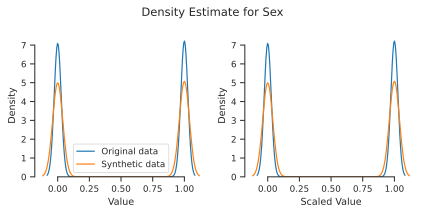

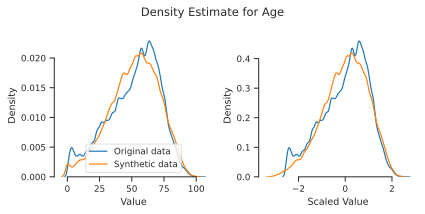

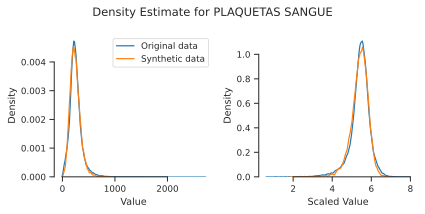

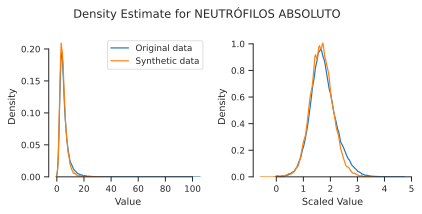

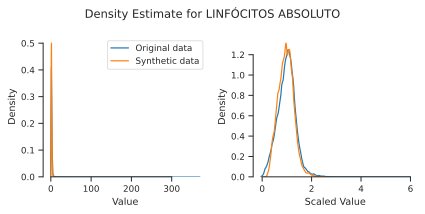

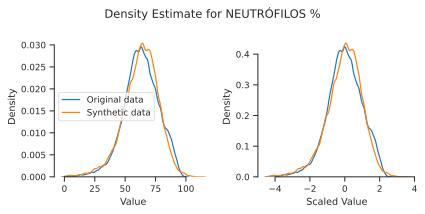

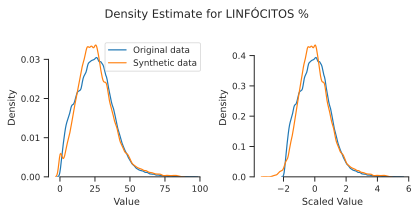

In [158]:
for i, t in enumerate(columns):
    fig, ax = plt.subplots(1, 2, figsize=(6, 3))
    sns.kdeplot(df_agg[t], label='Original data', ax=ax[0], bw_adjust=0.5)
    sns.kdeplot(df_samples[t], label='Synthetic data', ax=ax[0], bw_adjust=0.5)
    ax[0].set_xlabel('Value')
    ax[0].set_ylabel('Density')
    ax[0].legend()

    sns.kdeplot(X_scaled[:,i], label='Original data', ax=ax[1], bw_adjust=0.5)
    sns.kdeplot(samples[:,i], label='Synthetic data', ax=ax[1], bw_adjust=0.5)
    ax[1].set_xlabel('Scaled Value')
    ax[1].set_ylabel('Density')

    plt.suptitle(f"Density Estimate for {t}")
    plt.tight_layout()
    sns.despine(trim=True)
    plt.savefig(f'./fig/VAE_dens_{i}.png')
    plt.show()

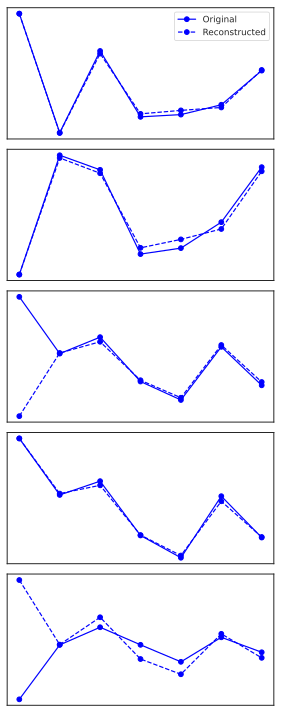

In [159]:
inputs = X_test[:5]
reconstruction_fig(model, inputs, scaler, scaled=True)
plt.savefig(f'./fig/VAE_recon.png')
plt.show()